In [1]:
#importing all the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("traces_data.csv",
                 skiprows=1,
                 names=["Timestamp", "traceID", "spanID", "parentSpanID", "serviceName", "Name", "durationNano","grpc"]
)

In [3]:
df.head()

,Timestamp,traceID,spanID,parentSpanID,serviceName,Name,durationNano,grpc
0,2023-11-23 04:42:32.707303516,d8d992638d73274d0a6710a1f9d17f93,0d87dcf5ea5aeaab,NaN,featureflagservice,/,887477,NaN
1,2023-11-23 04:42:32.707459680,d8d992638d73274d0a6710a1f9d17f93,bd0a6f75f1a901b7,0d87dcf5ea5aeaab,featureflagservice,featureflagservice.repo.query:featureflags,481634,NaN
2,2023-11-23 04:42:33.930086000,fab7ab123d61c8d7d71062fc44ffb87e,fe4acd4c8a763d24,NaN,frontend-proxy,ingress,213000,NaN
3,2023-11-23 04:42:36.928455000,39a34f6b196aa69cdd5364bfc73b35b4,b3c68f9f4a73524b,NaN,frontend-proxy,ingress,602000,NaN
4,2023-11-23 04:42:39.923633000,61e0ffa4c695a832b05f406999cf319c,b204b9bce1b3ac35,NaN,frontend-proxy,ingress,556000,NaN


In [4]:
#There was an extra column with grpc values which was not relevant so I removed that column
df.drop('grpc', axis = 1, inplace = True)

In [5]:
df.head()

,Timestamp,traceID,spanID,parentSpanID,serviceName,Name,durationNano
0,2023-11-23 04:42:32.707303516,d8d992638d73274d0a6710a1f9d17f93,0d87dcf5ea5aeaab,NaN,featureflagservice,/,887477
1,2023-11-23 04:42:32.707459680,d8d992638d73274d0a6710a1f9d17f93,bd0a6f75f1a901b7,0d87dcf5ea5aeaab,featureflagservice,featureflagservice.repo.query:featureflags,481634
2,2023-11-23 04:42:33.930086000,fab7ab123d61c8d7d71062fc44ffb87e,fe4acd4c8a763d24,NaN,frontend-proxy,ingress,213000
3,2023-11-23 04:42:36.928455000,39a34f6b196aa69cdd5364bfc73b35b4,b3c68f9f4a73524b,NaN,frontend-proxy,ingress,602000
4,2023-11-23 04:42:39.923633000,61e0ffa4c695a832b05f406999cf319c,b204b9bce1b3ac35,NaN,frontend-proxy,ingress,556000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183615 entries, 0 to 183614
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Timestamp     183615 non-null  object
 1   traceID       183615 non-null  object
 2   spanID        183615 non-null  object
 3   parentSpanID  141834 non-null  object
 4   serviceName   183615 non-null  object
 5   Name          183615 non-null  object
 6   durationNano  183615 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 9.8+ MB


In [7]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [8]:
df.describe()

,durationNano
count,1.836150e+05
mean,5.414918e+06
std,2.077879e+07
min,0.000000e+00
25%,3.357000e+05
50%,1.584906e+06
75%,6.832718e+06
max,4.999858e+09


In [9]:
print(df.isnull().sum())

Timestamp           0
traceID             0
spanID              0
parentSpanID    41781
serviceName         0
Name                0
durationNano        0
dtype: int64


parentSpanID has lot of null values, because some spans doesnt have any parentSpan

In [10]:
# Group by 'serviceName' and calculate average duration
service_duration = df.groupby('serviceName')['durationNano'].mean().sort_values(ascending=False)

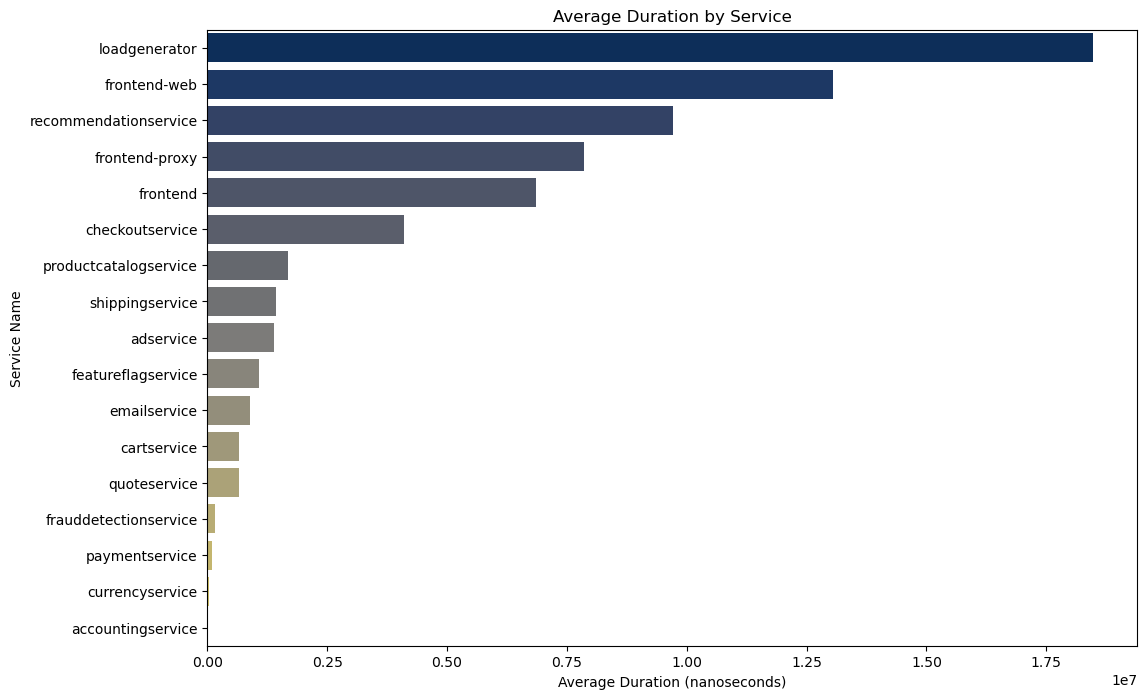

In [11]:
# Visualize average duration by service
plt.figure(figsize=(12, 8))
sns.barplot(x=service_duration.values, y=service_duration.index, palette='cividis')
plt.title('Average Duration by Service')
plt.xlabel('Average Duration (nanoseconds)')
plt.ylabel('Service Name')
plt.show()

In [12]:
# Group by 'Name' and calculate average duration
method_duration = df.groupby('Name')['durationNano'].mean().sort_values(ascending=False)

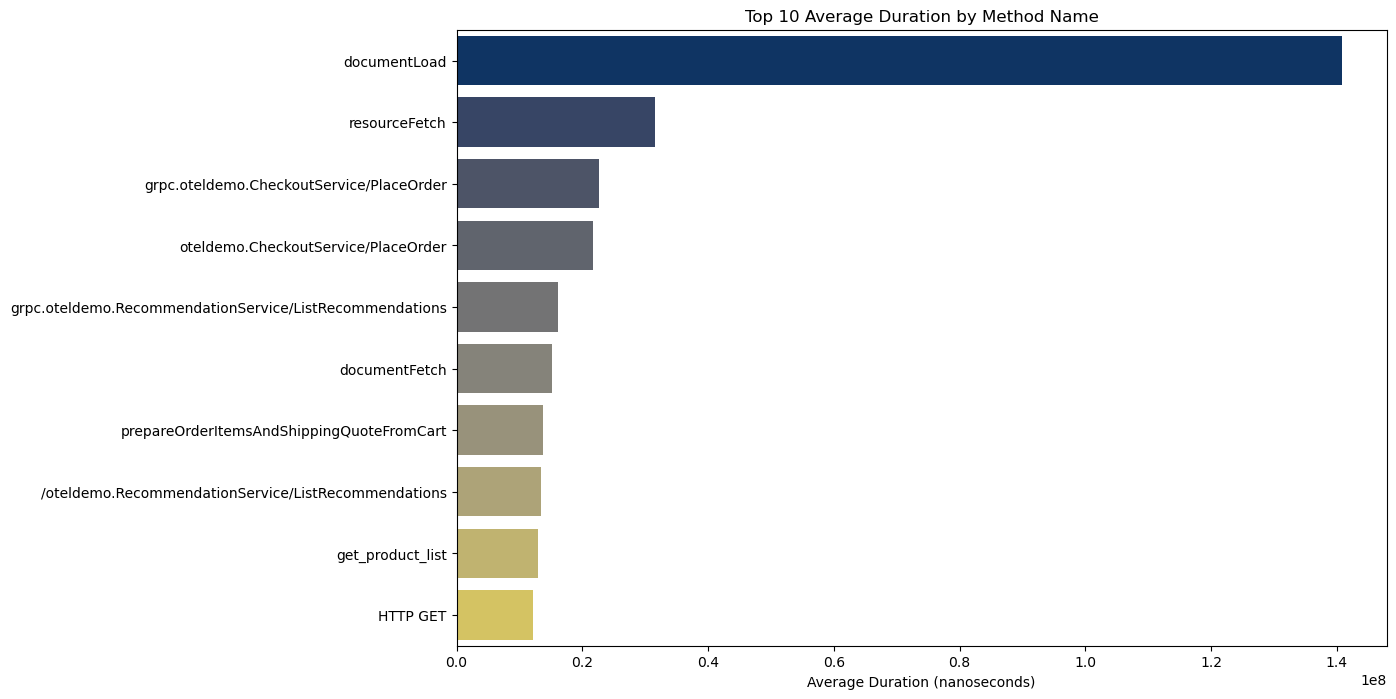

In [13]:
# Visualize average duration by method name
plt.figure(figsize=(12, 8))
sns.barplot(x=method_duration.values[:10], y=method_duration.index[:10], palette='cividis')
plt.title('Top 10 Average Duration by Method Name')
plt.xlabel('Average Duration (nanoseconds)')
plt.ylabel('')
plt.show()

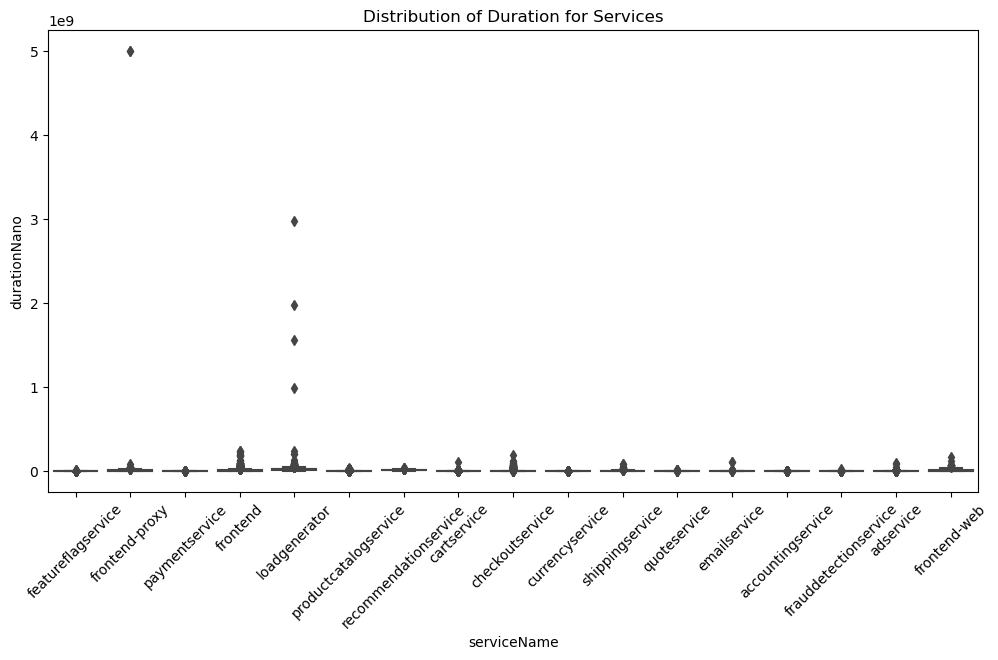

In [14]:
# Explore the distribution of duration for services
plt.figure(figsize=(12, 6))
sns.boxplot(x='serviceName', y='durationNano', data=df)
plt.title('Distribution of Duration for Services')
plt.xticks(rotation=45)
plt.show()

**Note:** frontend-proxy and loadgenerator services has some large outlier values, that means there is an anomaly in these services during some traces.

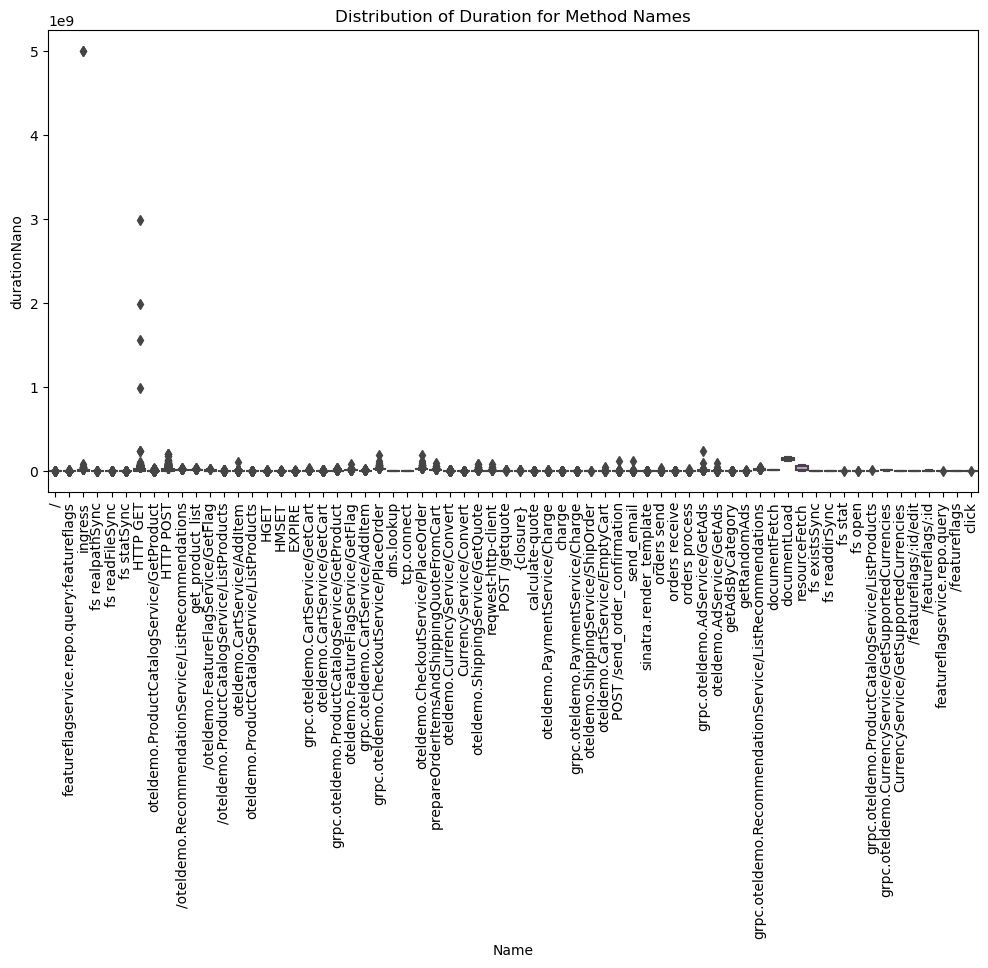

In [15]:
# Explore the distribution of duration for method names
plt.figure(figsize=(12, 6))
sns.boxplot(x='Name', y='durationNano', data=df)
plt.title('Distribution of Duration for Method Names')
plt.xticks(rotation=90)
plt.show()

**Note:** HTTP and ingress methods have ver huge outliers in this case.

In [16]:
# Taking the maximum duration of a unique traceID, because the trace with the Largest Duration is the Parent span
trace_duration = df.groupby("traceID")["durationNano"].max().sort_values(ascending=False)

In [17]:
# Calculate the IQR (Interquartile Range)
Q1 = trace_duration.quantile(0.25)
Q3 = trace_duration.quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [18]:
#Identify outliers in trace using duration length
outliers = trace_duration[(trace_duration < lower_bound) | (trace_duration > upper_bound)]

In [19]:
# Display outliers
print("Outliers:")
print(outliers)

Outliers:
traceID
6bb93cf92f5f3f3593f6847745e3e432    4999858000
ddefcb937f8445b6554e343738702138    4996859000
0a4c8b2a204f67623bcfbda629a07fc5    2980831627
605b2ed4e56586df16602ef85673fc83    1980473681
86d69278c14a4670bb1be847e7ea5184    1556061636
                                       ...    
f632ce8a9929eaf18f8880bfba589e07      41067851
8532d4905573dbca961a86db0792759c      41062146
1d1a47bab45d879848b493c39632a2d5      41053952
395501d34530f243c9562229d5a3d3d2      41049213
614f2d32b25d00a6fca4b3f13ec036fc      41047392
Name: durationNano, Length: 956, dtype: int64


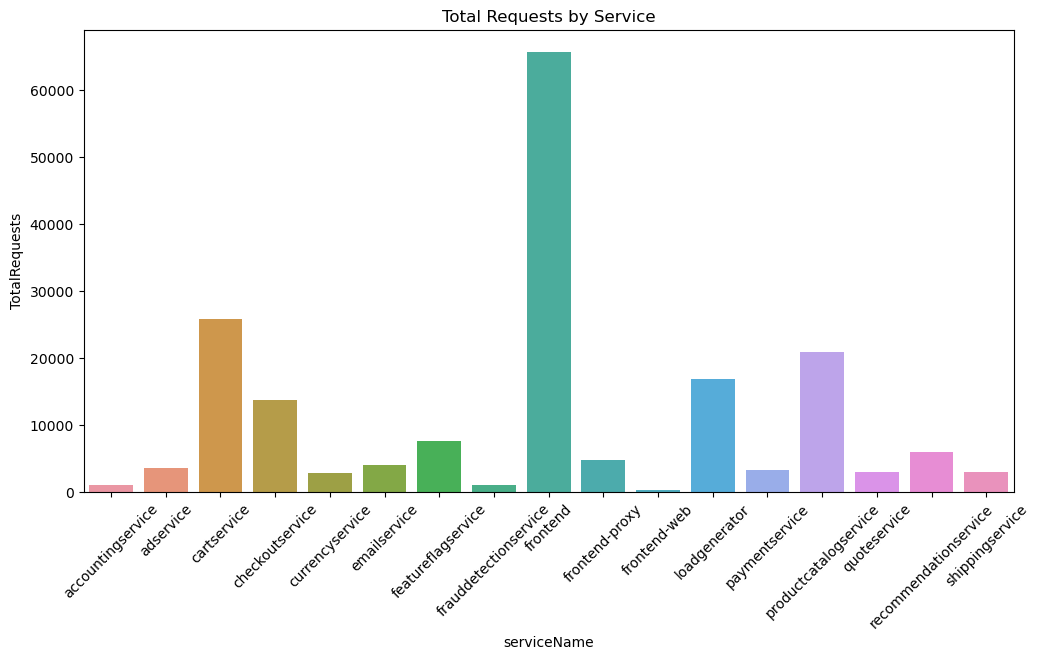

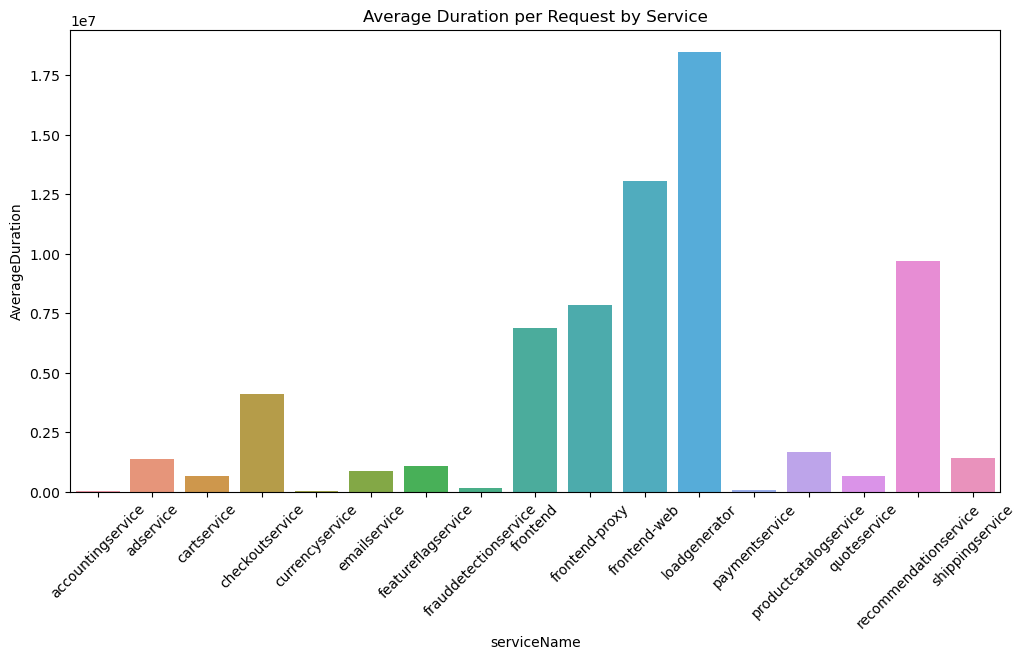

In [20]:
# Aggregate workload metrics by serviceName
workload_metrics = df.groupby('serviceName').agg({
    'durationNano': ['count', 'sum', 'mean']  # Total requests, total duration, average duration per request
}).reset_index()

# Rename columns for clarity
workload_metrics.columns = ['serviceName', 'TotalRequests', 'TotalDuration', 'AverageDuration']

# Visualize workload distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='serviceName', y='TotalRequests', data=workload_metrics)
plt.title('Total Requests by Service')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='serviceName', y='AverageDuration', data=workload_metrics)
plt.title('Average Duration per Request by Service')
plt.xticks(rotation=45)
plt.show()

**Note:** frauddetectionservice frontend has a lot of requests in one day.

## Question 2:

* **Isolation Forest**: Utilize Isolation Forest algorithm, which is an ensemble-based anomaly detection algorithm. It identifies anomalies by isolating them in the feature space. Isolation Forest(IF) is similar to Random Forest and it is build based on decision trees. There are no pre-defined labels here. It's an unsupervised learning algorithm that identifies anomaly by isolating outliers in the data.Since the Isolation Forest algorithm is based on the principle that anomalies are observations that are few and different, this should make them easier to identify.Isolation Forest does not assume normal distribution and is able to detect outliers at a multi-dimensional level. Isolation Forest is computationally efficient: the algorithm has a linear time complexity with a low constant and a low memory requirement. Therefore, it scales well to large data sets.

OR

* **One-Class SVM**: Train a One-Class SVM model on the duration data, which learns the normal pattern of durations and flags instances that deviate significantly from this pattern.

* **Autoencoders**: Use autoencoder neural networks to learn the normal pattern of durations. Instances with high reconstruction error are considered anomalies.